In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from scipy.stats import chi2_contingency
import numpy as np
from IPython.display import display
import ipywidgets as widgets

class BasicAnalysis:
    def __init__(self, df=None, filename=None):
        if filename:
            self.df = pd.read_csv(filename)
        elif df is not None:
            self.df = df
        else:
            uploader = widgets.FileUpload(accept='.csv', multiple=False)
            display(uploader)
            while not uploader.value:
                pass
            file_info = next(iter(uploader.value.values()))
            content = file_info['content']
            self.df = pd.read_csv(io.BytesIO(content))

    def shape(self):
        return self.df.shape

    def head(self, n=5):
        return self.df.head(n)

    def tail(self, n=5):
        return self.df.tail(n)

    def information(self):
        return self.df.info()

    def data_types(self):
        return self.df.dtypes

    def statistics(self):
        return self.df.describe()

    def find_columns(self):
        return self.df.columns.tolist()

    def find_null(self):
        return self.df.isnull().sum()

    def null_percentage(self):
        return (self.df.isnull().mean() * 100).round(2).sort_values(ascending=False)

    def null_heatmap(self):
        plt.figure(figsize=(10,6))
        sns.heatmap(self.df.isnull(), cbar=False, cmap='viridis')
        plt.title("Missing Values Heatmap")
        plt.show()

    def find_duplicated(self):
        return self.df.duplicated().sum()
    
    def fillna_(self, col_name, value):
        self.df[col_name] = self.df[col_name].fillna(value)
        return self.df
        
    def drop_duplicates(self):
        self.df.drop_duplicates(inplace=True)

    def drop_nulls(self):
        self.df.dropna(inplace=True)

    def unique_counts(self):
        return self.df.nunique()

    def replace_values(self, column_name, old, new):
        if column_name not in self.df.columns:
            raise ValueError(f"{column_name} not in DataFrame")
        self.df[column_name].replace({old: new}, inplace=True)

    def unique_values(self, column_name):
        if column_name not in self.df.columns:
            raise ValueError(f"{column_name} not in DataFrame")
        return self.df[column_name].unique()

    def value_counts(self, column_name):
        if column_name not in self.df.columns:
            raise ValueError(f"{column_name} not in DataFrame")
        return self.df[column_name].value_counts()

    def correlation_matrix(self):
        return self.df.corr(numeric_only=True)

    def categorical_summary(self):
        summary = {}
        cat_cols = self.df.select_dtypes(include='object').columns
        for col in cat_cols:
            summary[col] = self.df[col].value_counts()
        return summary

    def detect_outlier(self, column_name):
        if column_name not in self.df.columns:
            raise ValueError(f"{column_name} not found in DataFrame.")
        col = pd.to_numeric(self.df[column_name], errors='coerce').dropna()
        Q1 = col.quantile(0.25)
        Q3 = col.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mean_val = col.mean()
        print(f"Lower Bound: {lower_bound} and Upper Bound: {upper_bound} and Mean: {mean_val}")
        outliers = self.df[(self.df[column_name] < lower_bound) |
                           (self.df[column_name] > upper_bound)]
        return outliers[column_name].tolist()

    def plot_column_distribution(self, column_name):
        if column_name not in self.df.columns:
            raise ValueError(f"{column_name} not in DataFrame")
        plt.figure(figsize=(8,4))
        sns.histplot(self.df[column_name].dropna(), kde=True)
        plt.title(f'Distribution of {column_name}')
        plt.show()

    def PCC(self):
        numerical = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        data = self.df[numerical].dropna()
        corr_matrix = np.corrcoef(data.T)
        corelated_columns = []
        for i in range(1,len(numerical)):
            for j in range(i + 1, len(numerical)):
                col1 = numerical[i]
                col2 = numerical[j]
                confusion_matrix = pd.crosstab(self.df[col1], self.df[col2])
                corr_value=corr_matrix[0][1]
                if corr_value < 0.05 or corr_value >-0.05:
                    corelated_columns.append({(col1, col2): corr_value})
        return corelated_columns
    def chi_square(self):
        categorical = self.df.select_dtypes(include=['object']).columns.tolist()
        data = self.df[categorical].dropna()
        correlated_columns = []

        for i in range(len(categorical)):
            for j in range(i + 1, len(categorical)):
                col1 = categorical[i]
                col2 = categorical[j]
                contingency_table = pd.crosstab(data[col1], data[col2])

            # Check if contingency table is valid (at least 2 rows and 2 columns)
                if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                    continue

                chi2, p_value, _, _ = chi2_contingency(contingency_table)

                if p_value < 0.05:
                    correlated_columns.append({(col1, col2): p_value})

        return correlated_columns


        
    def column_types(self):
        categorical = self.df.select_dtypes(include='object').columns.tolist()
        numerical = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        return {'categorical': categorical, 'numerical': numerical}

    def count_plots(self, column_name):
        if column_name not in self.df.columns:
            raise ValueError(f"'{column_name}' not found in DataFrame.")
        if self.df[column_name].dtype != 'object':
            raise TypeError(f"'{column_name}' is not a categorical (object) column.")
        plt.figure(figsize=(8, 4))
        sns.countplot(x=column_name, data=self.df, palette="Set2")
        plt.title(f'Count Plot for {column_name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def boxplots(self, name):
        plt.figure(figsize=(6, 4))
        sns.boxplot(y=self.df[name], color='skyblue')
        plt.title(f'Boxplot of {name}')
        plt.ylabel(name)
        plt.tight_layout()
        plt.show()

    def scatter_plot(self, x_col, y_col):
        plt.figure(figsize=(7, 5))
        sns.scatterplot(x=self.df[x_col], y=self.df[y_col], color='teal')
        plt.title(f'Scatter Plot of {x_col} vs {y_col}')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.tight_layout()
        plt.show()

    def stacked_bar(self, x_col, y_col):
        pd.crosstab(self.df[x_col], self.df[y_col], normalize='index') \
          .plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 5))
        plt.title(f'{x_col} vs {y_col}')
        plt.xlabel(x_col)
        plt.ylabel('Proportion')
        plt.legend(title=y_col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def pie_chart(self, column):
        self.df[column].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%',startangle=90, colormap='Set3',figsize=(6, 6),wedgeprops={'edgecolor': 'black'})
        plt.title(f'Pie Chart of {column}')
        plt.tight_layout()
        plt.show()

    def bar_plot(self, category_col, value_col):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=category_col, y=value_col, data=self.df, palette='viridis')
        plt.title(f'Bar Plot of {category_col} vs {value_col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [20]:
a=BasicAnalysis(filename="train.csv")

In [3]:
a.PCC()

[{('MSSubClass', 'LotFrontage'): 0.021937478536860133},
 {('MSSubClass', 'LotArea'): 0.021937478536860133},
 {('MSSubClass', 'OverallQual'): 0.021937478536860133},
 {('MSSubClass', 'OverallCond'): 0.021937478536860133},
 {('MSSubClass', 'YearBuilt'): 0.021937478536860133},
 {('MSSubClass', 'YearRemodAdd'): 0.021937478536860133},
 {('MSSubClass', 'MasVnrArea'): 0.021937478536860133},
 {('MSSubClass', 'BsmtFinSF1'): 0.021937478536860133},
 {('MSSubClass', 'BsmtFinSF2'): 0.021937478536860133},
 {('MSSubClass', 'BsmtUnfSF'): 0.021937478536860133},
 {('MSSubClass', 'TotalBsmtSF'): 0.021937478536860133},
 {('MSSubClass', '1stFlrSF'): 0.021937478536860133},
 {('MSSubClass', '2ndFlrSF'): 0.021937478536860133},
 {('MSSubClass', 'LowQualFinSF'): 0.021937478536860133},
 {('MSSubClass', 'GrLivArea'): 0.021937478536860133},
 {('MSSubClass', 'BsmtFullBath'): 0.021937478536860133},
 {('MSSubClass', 'BsmtHalfBath'): 0.021937478536860133},
 {('MSSubClass', 'FullBath'): 0.021937478536860133},
 {('MSSubC

In [21]:
a.chi_square()

[]

In [18]:
a.data_types()

Order ID                   object
Customer ID                object
Platform                   object
Order Date & Time          object
Delivery Time (Minutes)     int64
Product Category           object
Order Value (INR)           int64
Customer Feedback          object
Service Rating              int64
Delivery Delay             object
Refund Requested           object
dtype: object

In [9]:
a.shape()

(100000, 11)

In [10]:
a.head()

,Order ID,Customer ID,Platform,Order Date & Time,Delivery Time (Minutes),Product Category,Order Value (INR),Customer Feedback,Service Rating,Delivery Delay,Refund Requested
0,ORD000001,CUST2824,JioMart,19:29.5,30,Fruits & Vegetables,382,"Fast delivery, great service!",5,No,No
1,ORD000002,CUST1409,Blinkit,54:29.5,16,Dairy,279,Quick and reliable!,5,No,No
2,ORD000003,CUST5506,JioMart,21:29.5,25,Beverages,599,Items missing from order.,2,No,Yes
3,ORD000004,CUST5012,JioMart,19:29.5,42,Beverages,946,Items missing from order.,2,Yes,Yes
4,ORD000005,CUST4657,Blinkit,49:29.5,30,Beverages,334,"Fast delivery, great service!",5,No,No


In [11]:
a.tail()

,Order ID,Customer ID,Platform,Order Date & Time,Delivery Time (Minutes),Product Category,Order Value (INR),Customer Feedback,Service Rating,Delivery Delay,Refund Requested
99995,ORD099996,CUST5324,JioMart,49:29.5,24,Dairy,289,Packaging could be better.,3,No,No
99996,ORD099997,CUST1677,JioMart,18:29.5,19,Snacks,322,Good quality products.,4,No,No
99997,ORD099998,CUST8198,JioMart,27:29.5,41,Dairy,135,"Fast delivery, great service!",5,Yes,No
99998,ORD099999,CUST9975,JioMart,14:29.5,31,Grocery,973,Quick and reliable!,5,No,No
99999,ORD100000,CUST3748,JioMart,41:29.5,34,Fruits & Vegetables,453,Packaging could be better.,3,No,No


In [12]:
a.information()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Order ID                 100000 non-null  object
 1   Customer ID              100000 non-null  object
 2   Platform                 100000 non-null  object
 3   Order Date & Time        100000 non-null  object
 4   Delivery Time (Minutes)  100000 non-null  int64 
 5   Product Category         100000 non-null  object
 6   Order Value (INR)        100000 non-null  int64 
 7   Customer Feedback        100000 non-null  object
 8   Service Rating           100000 non-null  int64 
 9   Delivery Delay           100000 non-null  object
 10  Refund Requested         100000 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


In [13]:
a.find_columns()

['Order ID',
 'Customer ID',
 'Platform',
 'Order Date & Time',
 'Delivery Time (Minutes)',
 'Product Category',
 'Order Value (INR)',
 'Customer Feedback',
 'Service Rating',
 'Delivery Delay',
 'Refund Requested']

In [14]:
a.find_null()

Order ID                   0
Customer ID                0
Platform                   0
Order Date & Time          0
Delivery Time (Minutes)    0
Product Category           0
Order Value (INR)          0
Customer Feedback          0
Service Rating             0
Delivery Delay             0
Refund Requested           0
dtype: int64

In [15]:
a.find_duplicated()

0

In [16]:
a.unique_values("Product Category")

array(['Fruits & Vegetables', 'Dairy', 'Beverages', 'Personal Care',
       'Grocery', 'Snacks'], dtype=object)

In [17]:
a.value_counts("Service Rating")

Service Rating
5    38688
2    30552
1    15267
4     7789
3     7704
Name: count, dtype: int64

In [18]:
a.correlation_matrix()

,Delivery Time (Minutes),Order Value (INR),Service Rating
Delivery Time (Minutes),1.000000,0.007225,0.000136
Order Value (INR),0.007225,1.000000,-0.002689
Service Rating,0.000136,-0.002689,1.000000


In [19]:
a.correlation_between("Platform","Product Category")

(Product Category  Beverages  Dairy  Fruits & Vegetables  Grocery  \
 Platform                                                           
 Blinkit                5593   5643                 5576     5586   
 JioMart                5411   5586                 5546     5605   
 Swiggy Instamart       5532   5628                 5510     5546   
 
 Product Category  Personal Care  Snacks  
 Platform                                 
 Blinkit                    5463    5563  
 JioMart                    5436    5543  
 Swiggy Instamart           5634    5599  ,
 0.7544265224965951)

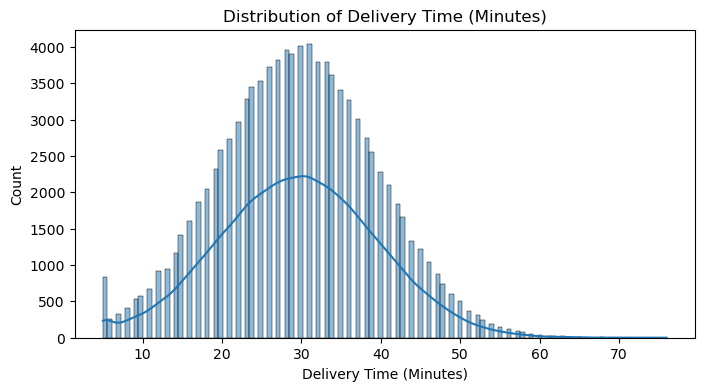

In [20]:
a.plot_column_distribution("Delivery Time (Minutes)")

In [21]:
a.detect_outlier("Order Value (INR)")

Lower Bound: -447.5 and Upper Bound: 1500.5 and Mean: 590.9944


[1939,
 1693,
 1651,
 1595,
 1956,
 1848,
 1690,
 1929,
 1727,
 1553,
 1634,
 1639,
 1534,
 1910,
 1864,
 1586,
 1585,
 1701,
 1767,
 1757,
 1756,
 1870,
 1637,
 1575,
 1702,
 1760,
 1887,
 1640,
 1524,
 1689,
 1811,
 1590,
 1690,
 1948,
 1768,
 1792,
 1917,
 1927,
 1824,
 1730,
 1841,
 1929,
 1813,
 1983,
 1709,
 1743,
 1693,
 1727,
 1711,
 1914,
 1736,
 1575,
 1613,
 1833,
 1934,
 1530,
 1630,
 1601,
 1602,
 1598,
 1927,
 1811,
 1960,
 1686,
 1586,
 1705,
 1834,
 1973,
 1963,
 1888,
 1675,
 1635,
 1814,
 1702,
 1527,
 1711,
 1625,
 1967,
 1749,
 1633,
 1731,
 1613,
 1792,
 1941,
 1881,
 1530,
 1770,
 1539,
 1932,
 1733,
 1778,
 1563,
 1594,
 1760,
 1504,
 1951,
 1545,
 1632,
 1697,
 1788,
 1845,
 1953,
 1780,
 1758,
 1956,
 1508,
 1965,
 1602,
 1778,
 1774,
 1889,
 1826,
 1665,
 1619,
 1841,
 1791,
 1918,
 1693,
 1609,
 1977,
 1948,
 1720,
 1974,
 1945,
 1626,
 1854,
 1926,
 1621,
 1534,
 1857,
 1865,
 1604,
 1543,
 1897,
 1797,
 1767,
 1847,
 1970,
 1843,
 1884,
 1556,
 2000,
 1655,

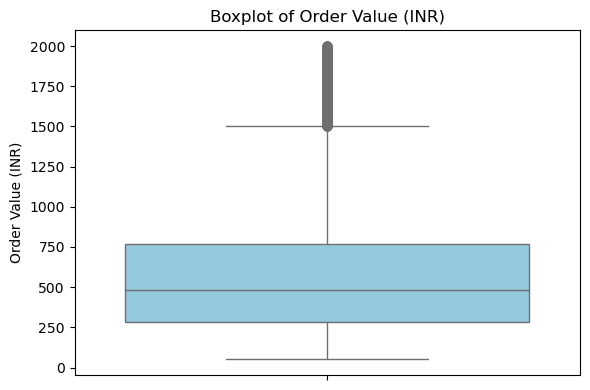

In [24]:
a.boxplots("Order Value (INR)")

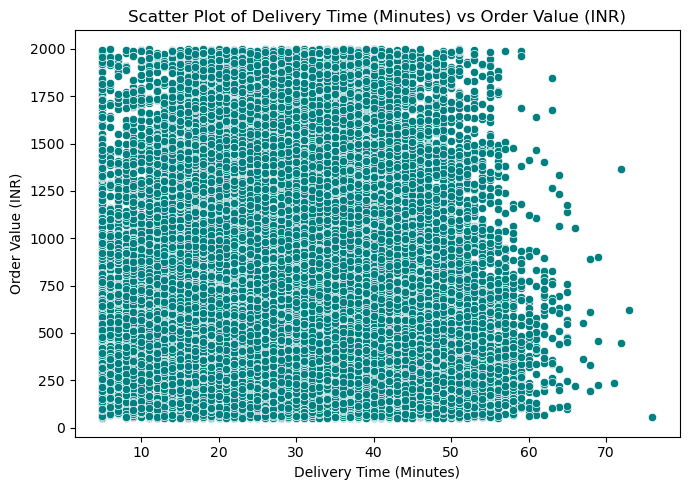

In [26]:
a.scatter_plot("Delivery Time (Minutes)","Order Value (INR)")

C:\Users\mared\AppData\Local\Temp\ipykernel_8984\2498847589.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_col, y=value_col, data=self.df, palette='viridis')


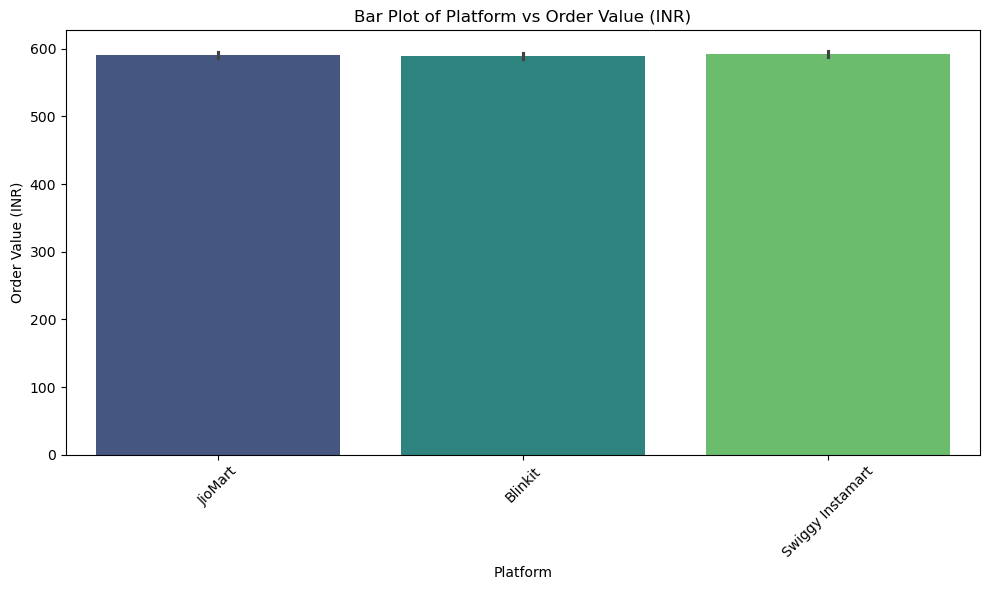

In [27]:
a.bar_plot("Platform","Order Value (INR)")

In [30]:
a.statistics()

,Order ID,Customer ID,Platform,Order Date & Time,Delivery Time (Minutes),Product Category,Order Value (INR),Customer Feedback,Service Rating,Delivery Delay,Refund Requested
count,100000,100000,100000,100000,100000.000000,100000,100000.000000,100000,100000.000000,100000,100000
unique,100000,9000,3,60,NaN,6,NaN,13,NaN,2,2
top,ORD000001,CUST8779,Swiggy Instamart,50:29.5,NaN,Dairy,NaN,"Easy to order, loved it!",NaN,No,No
freq,1,26,33449,1755,NaN,16857,NaN,7791,NaN,86328,54181
mean,NaN,NaN,NaN,NaN,29.536140,NaN,590.994400,NaN,3.240790,NaN,NaN
std,NaN,NaN,NaN,NaN,9.958933,NaN,417.409058,NaN,1.575962,NaN,NaN
min,NaN,NaN,NaN,NaN,5.000000,NaN,50.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,23.000000,NaN,283.000000,NaN,2.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,30.000000,NaN,481.000000,NaN,3.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,36.000000,NaN,770.000000,NaN,5.000000,NaN,NaN
